### 2020 Lavickova et al. A self-regenerating synthetic cell model: Model plots, alternative models
Nadanai Laohakunakorn (University of Edinburgh), nadanai.laohakunakorn@ed.ac.uk

In [1]:
using DelimitedFiles
using Plots
using DifferentialEquations
using ProgressBars
using Statistics
using PyCall

include("../scripts/models.jl");
include("../scripts/callbacks.jl");
include("../scripts/solve.jl");

In [2]:
# Global settings
Plots.pyplot()
PATH_OUT = "../output/"
fntsm = Plots.font("sans-serif", pointsize=round(14.0))
fntlg = Plots.font("sans-serif", pointsize=round(18.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)

TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.2;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between experimental stages

# Define names for species indices
idx_R=1;
idx_dT=2;
idx_dG=3;
idx_mT=4;
idx_mG=5;
idx_pT=6;
idx_pG=7;

idx_TX = 8;
idx_TL = 9;

## 4. Alternative models 

## 4.1 Resource independent, TL coupling

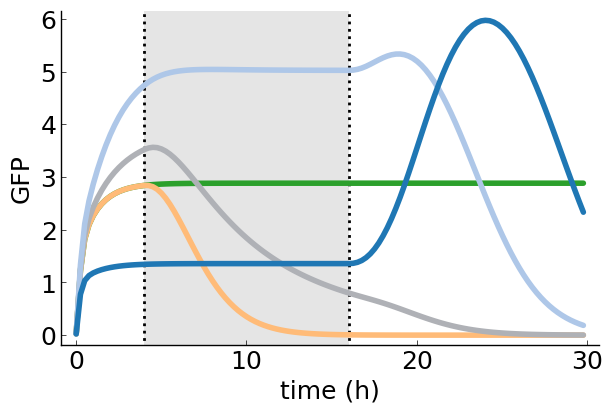

In [3]:
CONCS = [0.1,0.6,10]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP_RI_.pdf"

# Set initial conditions

R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.3#1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
TXNC = [datum for subarr in solU.u for datum in subarr[8]];


plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

93.3%┣███████████████████████████████████████▏  ┫ 28/30 [00:02<00:00, 13.5 it/s]

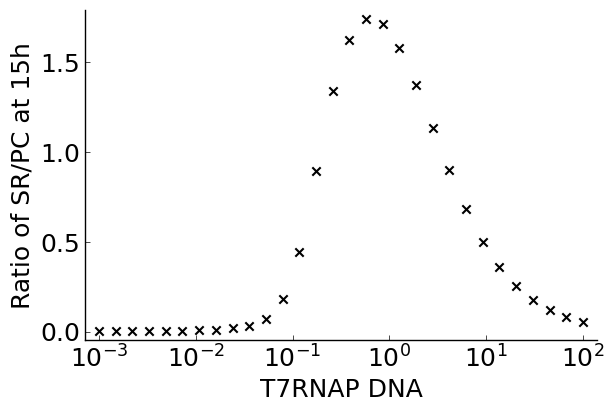

100.0%┣█████████████████████████████████████████┫ 30/30 [00:02<00:00, 14.0 it/s]


In [4]:
# Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
FN="ratio_GFP_RI.pdf"
# Set initial conditions


R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.3#1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RI(grads_RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)

## 4.2 Resource independent, no TL coupling

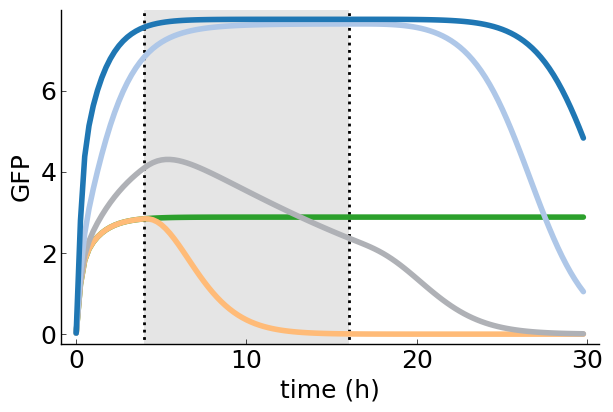

In [5]:
# 1.1 Resource independent, no TL coupling
CONCS = [0.1,0.6,10]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP_RInl_.pdf"

# Set initial conditions

R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.3#1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
TXNC = [datum for subarr in solU.u for datum in subarr[8]];


plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

93.3%┣███████████████████████████████████████▏  ┫ 28/30 [00:02<00:00, 16.5 it/s]

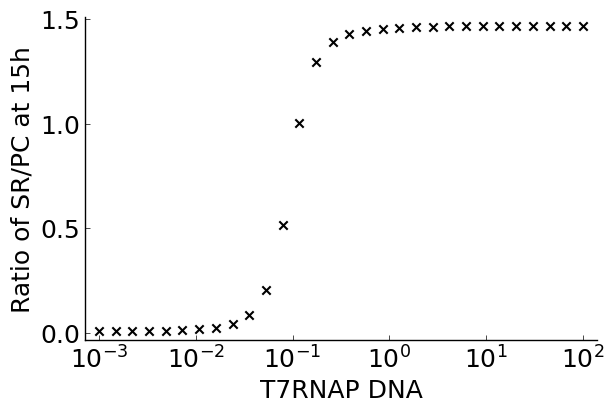

100.0%┣█████████████████████████████████████████┫ 30/30 [00:02<00:00, 16.9 it/s]


In [6]:
# Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
FN="ratio_GFP_RInl.pdf"
# Set initial conditions

R0=0.0; # not used
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=1.0;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=10;
beta=1;
lamb1=0.1;
lamb2=0.1;
KTL=100;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL];
    solU,solDU=solvemodel_RInl(grads_RInl,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)

## 4.3 Combined resource usage + resource independent termination + TL coupling

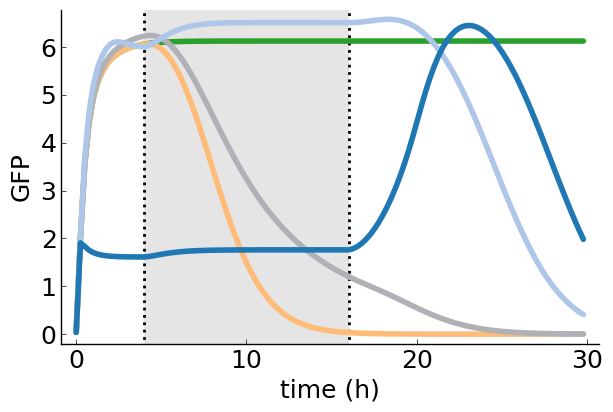

In [7]:
# 1.3 1R+RI model
CONCS = [0.01,0.1,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP_1RI.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

96.7%┣█████████████████████████████████████████▋ ┫ 29/30 [00:03<00:00, 8.2 it/s]

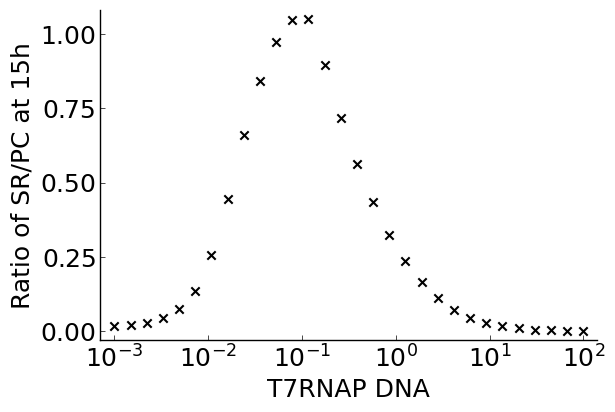

100.0%┣██████████████████████████████████████████┫ 30/30 [00:04<00:00, 8.1 it/s]


In [8]:
# Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
FN="ratio_GFP_1RI.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K];
    solU,solDU=solvemodel_1RI(grads_1RI,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)

## 4.4 Combined resource usage + resource independent termination + TX/TL coupling

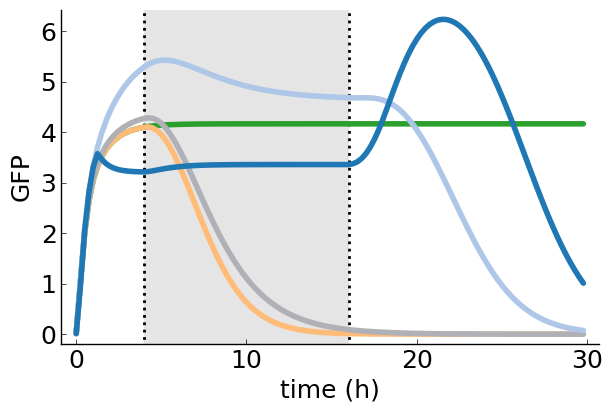

In [9]:
# 1.4 full model

TMAX = 30.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.2;
NSPECIES = 7
SWITCHTIMES = [4.0,16.0] # Time to swap between stages

CONCS = [0.01,0.1,1]
LABELS = ["SR low", "SR medium", "SR high"]
COLOURS = ["#afb1b6","#aec7e8","#1f77b4"]
p1 = plot(grid=:false,legend=:false)#,legend=:outertopright)
vspan!([4,16],fill=:black,alpha=:0.1); vline!([4,16],color=:black,linestyle=:dot,linewidth=2);
FN="TS_GFP_1RIc.pdf"

# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
KTX=1;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];

#TSAVE = 0.0:5.0:TMAX # either array or range can be passed
TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"NC");
pGNC = [datum for subarr in solU.u for datum in subarr[idx_pG]];

plot!(t,pGPC,label="PC",color="#2ca02c",xaxis="time (h)",yaxis="GFP",lw=4);
plot!(t,pGNC,label="NC",color="#ffbb78",lw=4)

for j in (1:size(CONCS)[1])
    dT0=CONCS[j]
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];
    solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    plot!(t,pG,label=LABELS[j],color=COLOURS[j],lw=4)
end

p1 # Show plot
savefig(PATH_OUT*FN)

96.7%┣████████████████████████████████████████▋ ┫ 29/30 [00:02<00:00, 13.4 it/s]

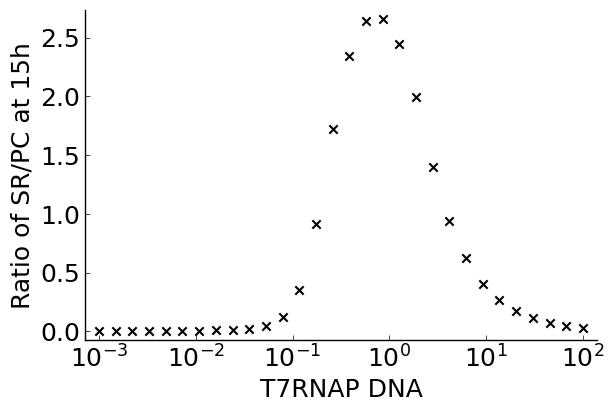

100.0%┣█████████████████████████████████████████┫ 30/30 [00:02<00:00, 12.2 it/s]


In [10]:
# Ratio curve
CONCS = exp10.(range(-3, stop=2, length=30))
ratio_SRPC = []
FN="ratio_GFP_1RIc.pdf"
# Set initial conditions

R0=100.0;
dT0=0.0;
dG0=2.0;
mT0=0.0;
mG0=0.0;
pT0=0.18;
pG0=0.0;
TX0=1.0;
TL0=1.0;

alpha=5;
beta=0.5;
lamb1=0.05;
lamb2=0.05;
KTL=10;
KTX=10;
K=1;
u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];

TSAVE = collect(0:15:TMAX).+1 
solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"PC");
t = solU.t/60;
pGPC = [datum for subarr in solU.u for datum in subarr[idx_pG]];
# Index at 15h
idx = findall(x -> x == 901,TSAVE)

for conc in ProgressBar(CONCS)
    dT0=conc
    u0 = [R0,dT0,dG0,mT0,mG0,pT0,pG0,TX0,TL0];
    params = [alpha,beta,lamb1,lamb2,KTL,K,KTX];
    solU,solDU=solvemodel_1RIf(grads_1RIf,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,"SR");
    pG = [datum for subarr in solU.u for datum in subarr[idx_pG]];
    append!(ratio_SRPC,pG[idx]/pGPC[idx])
end

plot(CONCS,ratio_SRPC,seriestype=:scatter,xaxis="T7RNAP DNA",yaxis="Ratio of SR/PC at 15h",
    xscale=:log10,markershape=:x,label="",color=:black,markersize=6,grid=:false)
savefig(PATH_OUT*FN)